# Online learning technical model for ETFs

### Based of etf_online30min_2020.04.13.ipynb
#### Removed all `log_open` and `log_dollar_volume` features since they might have a lookhead problem



In [8]:
import pandas as pd

df = pd.read_pickle( '/home/fj/experiments/spx-options/spock_strategy/2020.05.03_backtest_all_strikes/none/results_from_run/SPX_20200508_orders.bz2')
df[df.num_contracts !=0 ]

,strike,option_type,num_contracts,cost,limit_price,quote_datetime,symbol,expiry
11,2020.0,P,-69,-75.90,1.10,2020-04-23 10:00:00,SPX,2020-05-08
12,3025.0,C,2,14.00,7.00,2020-04-23 10:00:00,SPX,2020-05-08
47,2815.0,P,-2,-158.20,79.10,2020-04-23 10:00:00,SPX,2020-05-08
117,2030.0,P,-68,-78.20,1.15,2020-04-23 10:00:00,SPX,2020-05-08
118,2025.0,P,-86,-94.60,1.10,2020-04-23 10:00:00,SPX,2020-05-08
174,3020.0,C,1,7.60,7.60,2020-04-23 10:00:00,SPX,2020-05-08
203,2040.0,P,-22,-26.40,1.20,2020-04-23 10:00:00,SPX,2020-05-08
216,2180.0,P,89,222.50,2.50,2020-04-23 10:00:00,SPX,2020-05-08
268,2575.0,P,2,45.80,22.90,2020-04-23 10:00:00,SPX,2020-05-08
296,2010.0,P,-67,-70.35,1.05,2020-04-23 10:00:00,SPX,2020-05-08


NameError: name 'da' is not defined

In [1]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler

from io import BytesIO
from IPython.display import display, Image, HTML
from pylab import *
plt.style.use( 'seaborn-whitegrid' )
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()

from research import yahoo; reload( yahoo)

# create a configuration
mx.Config.name = 'etf_technical/online/2020.04.29'
mx.Config.start()
mx.Config.hps = mx.HPSet(
    # trade during market hours     
    market_hours=True,
    # trade after market hours
    pre_market=False,
    # trade pre market hours 
    post_market=False,
)
hps = mx.Config.hps

dh( mx.Config )


Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.


<IPython.core.display.Javascript object>

# Online linear model with 30min data
------
* 200 instruments
* Both global and single instrument models
* large numbers of features





/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


<IPython.core.display.Javascript object>


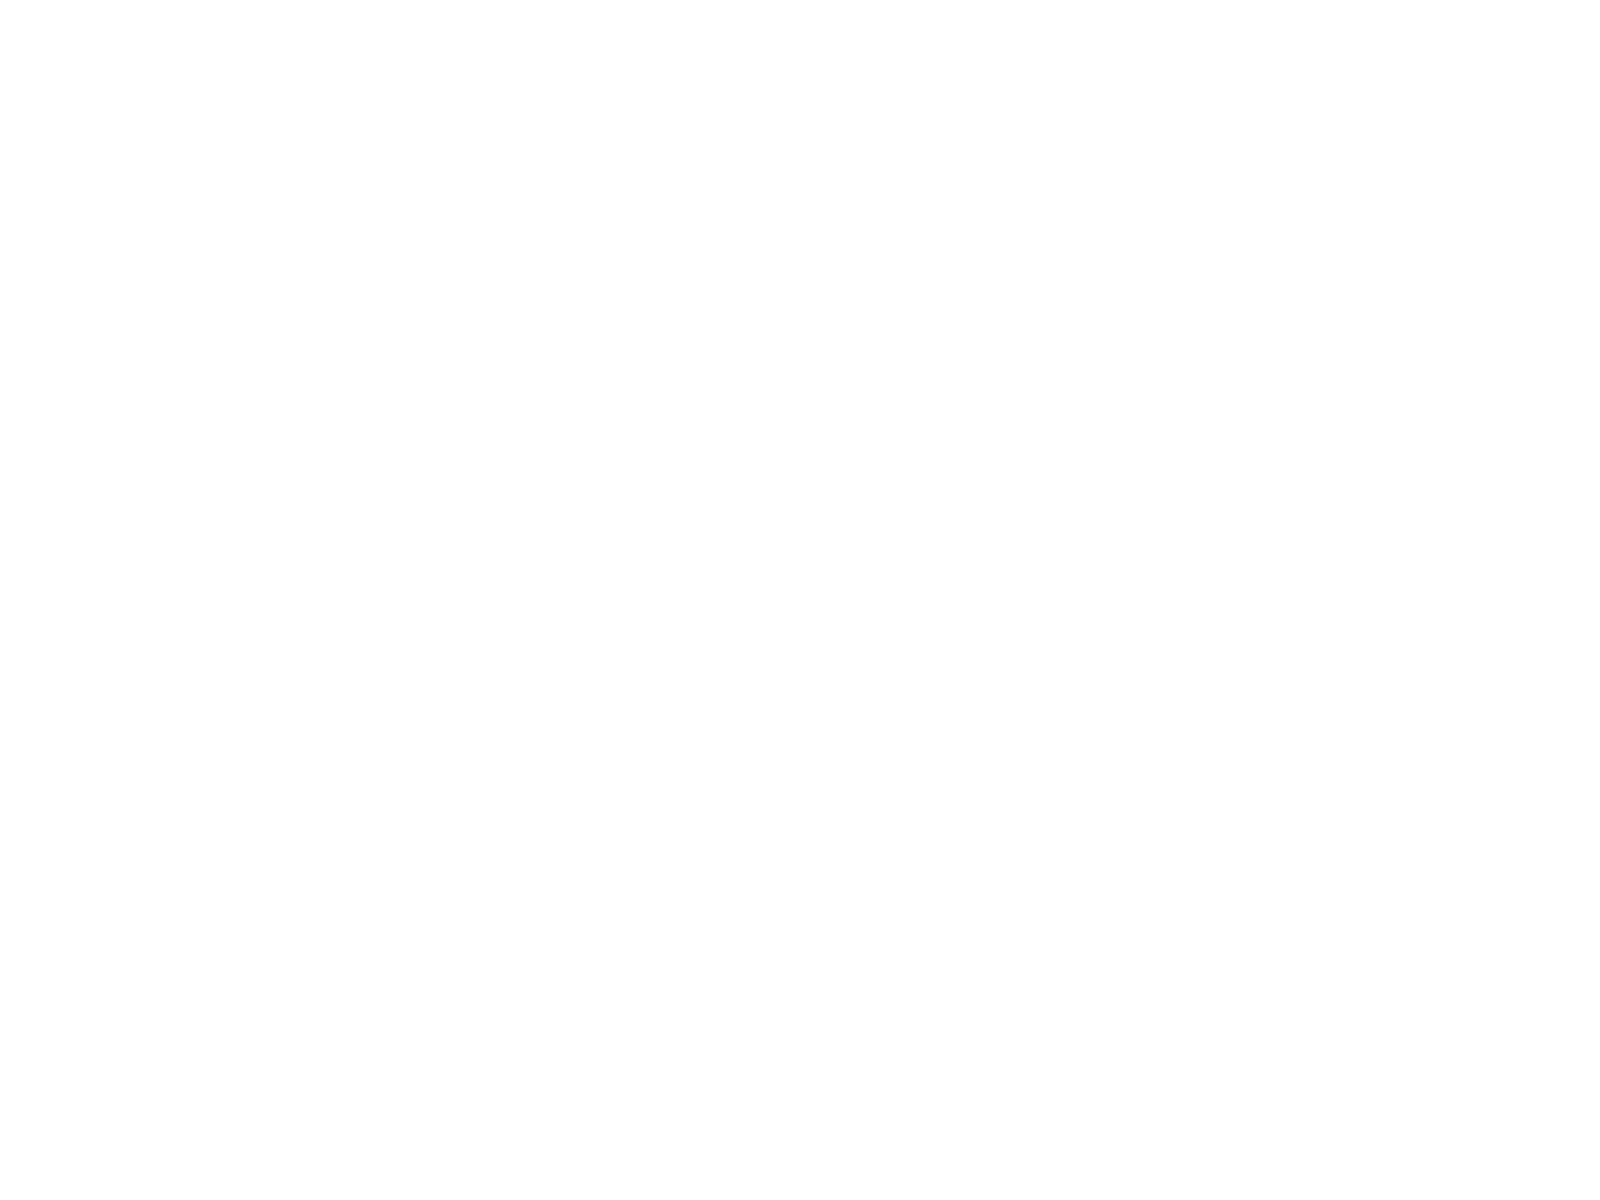

/home/fj/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [2]:
# Build up the 30min dataset and construct a bunch of features
####################################################################
%nbagg

from research.etf_technical import load_data as eld; reload( eld )

price_features = ['open_30min', 'high_30min', 'low_30min', 'close_30min', 
                      'open_day', 'high_day', 'low_day', 'close_day', 'close_prev_day', 
                      'open_week', 'high_week', 'low_week', 'close_week', 'close_prev_week', 
                      'open_month', 'high_month', 'low_month', 'close_month', ]
                      
volume_features = ['volume_30min', 'volume_intraday', 'volume_intraweek', 'volume_1hr', 'volume_1day', 
                       'dollar_volume_30min', 'dollar_volume_intraday',
                       'dollar_volume_intraweek', 'dollar_volume_1hr', 'dollar_volume_1day',]
                       
calendar_features = [ 'week', 'month', 'timeofday', 'dayofweek', 'dayofmonth', 
                          'weekofyear', 'cos_timeofday', 'sin_timeofday', 
                          'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth',
                          'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',]

returns_features = ['logrtn_lag_intraday', 'logrtn_lag_overnight', 'logrtn_lag_intraweek',
                    'logrtn_lag_weekend', 'logrtn_lag_intramonth', 'logrtn_lag_30min',
                    'logrtn_lag_1hr','logrtn_lag_1day', ]

responses = ['logrtn_lead_30min',  'logrtn_lead_1hr', 'logrtn_lead_1day'] #'logrtn_lead_intraday', 



@mx.operatorize( memoize='md', consumes_features=False, produces_meta=True )
def FeatureBuilder( data, responses=responses,  emv=True, ema=True, equalize_lagging_returns=False,
                    haar=False, dilation=2, levels=5, winsorize=0.05, smz=False,   
                   volume_features=volume_features, returns_features=returns_features, 
                   verbose=False ):
    '''
    build up the 30 min dataset for learning
    
    equalize_lagging_returns:
        divide out annual vol from all lagging returns features
        Leading returns features are equalized anyways
    '''
    INTS_PER_DAY = 13    
    logger = mx.Logger( 'build_features', verbose=verbose )        
    das = []
    with logger.timer( 'loading the data'):
        for symbol in logger.pbar( eld.kibot_day_files.keys() ):
            if symbol.startswith( 'INCOMPLETE' ):
                logger.warn( f'No data for {symbol} - SKIPPING' )
                continue
            logger.info( 'loading data for ', symbol )
            da, meta = eld.build_30min_data( symbol=symbol )
            das.append( da )    
        da = xa.concat( das, dim='symbol' )
    features = volume_features + returns_features
    with logger.timer( ' compute log features' ):
        for ft in ['dollar_volume_30min', 'open_30min', 'dollar_volume_intraday',  'dollar_volume_intraweek',] :
            da = da.assign_features( **{ f'log_{ft}': da.loc[:,:, ft].log() } )        
            features.append( f'log_{ft}' )
    with logger.timer(' compute an annual returns volatility'):
        avc = mx.transforms.rolling( windows='252D', sid='symbol', min_periods=INTS_PER_DAY*60 ).sd()
        da = avc( da, features='logrtn_lag_30min' )
        annual_vol = avc.output_features[0]
        # equalize the response variable
        equalized_responses = []
        for response in responses:
            equalized_response = f'{response}_equalized'
            da = da.assign_features( **{equalized_response: da.loc[:,:,response] / ( da.loc[:,:,annual_vol] + 1e-12 ) } )
            equalized_responses.append( equalized_response )        
    if equalize_lagging_returns:
        # equalize all the laggign returns columns inplace ....
        with logger.timer( 'compute "normalized" leading and lagging returns' ):            
            da.loc[:,:,returns_features] =  da.loc[:,:,returns_features] / ( da.loc[:,:,annual_vol] + 1e-12 )            
    # volume, price and returns vol
    if emv:
        with logger.timer( 'compute volatility' ):
            emv = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).sd()
            da = emv( da, features=['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day'] )
            features += emv.output_features
    # volume, price and returns sma
    if ema:
        with logger.timer( 'compute ema' ):
            ema = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).mean()            
            da = ema( da, features=['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day'] )
            features += ema.output_features        
    # compute haar transform
    if haar:
        with logger.timer( 'compute haar' ):
            haar = mx.transforms.haar( levels=levels, dilation=dilation, sid='symbol' )
            haar.features = ['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day'] 
            da = haar( da )
            features += haar.output_features
    # winsorize the features we've constructed and other good stuff
    if winsorize:
        with logger.timer( 'winsorizing' ):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=winsorize )
            wins.features = sorted( set(features + [annual_vol] + equalized_responses  ) )
            da = wins( da )
            # drop the original features and rename the winsorized one
            da = (da.drop_coords( features=wins.features )
                  .rename_coords( features=dict( zip( wins.output_features, wins.features ) ) ))
    # zscore the features
    if smz:
        with logger.timer( 'zscoring' ):
            zscore = mx.transforms.rolling( windows=smz, sid='symbol' ).zscore()
            da = zscore( da, features=features )
            # drop the original features and rename the zscored one
            # da = da.drop_coords( features=zscore.features ).rename_coords( features=dict( zip( zscore.output_features, zscore.features ) ) )
    # add a dummy weight column
    da = da.assign_features( one=1 )
    return da, features, dict( equalized_responses=equalized_responses, annual_vol=annual_vol )        

builder = FeatureBuilder()
da = builder( data=None )  

fig  = figure( figsize=(20, 15 ) )
sdf = da.loc[:,'SDY',:].to_dataframe_mx()
plt.style.use( 'seaborn-whitegrid')

ax = subplot( 2, 3, 1 )
ax.plot( sdf['open_day'], sdf['logrtn_lag_30min'].cumsum().exp(), '.r', alpha=0.5 )
ax.set_xlabel('open_day')
ax.set_ylabel('cum log lag 30min returns ')
ax = subplot( 2, 3, 2 )
ax.plot( sdf['logrtn_lead_30min'], sdf['logrtn_lag_30min'], '.r', alpha=0.5 )
ax.set_xlabel('logrtn_lead_30min')
ax.set_ylabel('logrtn_lag_30min ')
ax = subplot( 2, 3, 3 )
ax.plot( sdf['logrtn_lag_30min'].cumsum().exp(), '-b', label='30min lag')
ax.set_ylabel( '30min returns', color='blue')
ax.twinx().plot( sdf['logrtn_lag_1day'].cumsum().exp(), '--r', label='1 day lag')
ax.twinx().set_ylabel( '1 day returns', color='red')

ax = subplot( 2, 3, 4 )
ax.plot( sdf.tail(4000)['log_dollar_volume_30min'], '-k', alpha=0.3, label='log dv30')
ax.plot( sdf.tail(4000)['log_dollar_volume_30min_26.ew_mean'], '--r', label='log dv30 26ew')
ax.plot( sdf.tail(4000)['log_dollar_volume_30min_130.ew_mean'], '--b', label='log dv30 130ew')
ax.legend()

ax = subplot( 2, 3, 5 )
# ax.plot( da.loc[:,:,'logrtn_lead_30min_equalized'].to_series(), da.loc[:,:,'logrtn_lead_30min'].to_series(), '.r', alpha=0.5 )
ax.plot( sdf['logrtn_lag_30min_252D.rw_sd'], '--k' )
ax.set_ylabel('annual vol', color='black' )
# ax.twinx().plot( sdf['logrtn_lead_30min_equalized'], '-r', alpha=0.5 )
# ax.twinx().set_ylabel('equalized returns', color='red' )
ax.set_title('annual vol and equalized returns')
ax = subplot( 2, 3, 6 )
ax.plot( sdf['logrtn_lead_30min_equalized'].cumsum()/sdf['logrtn_lead_30min_equalized'].sum(), '-k', alpha=0.8, linewidth=3 , label='equalized' )
ax.plot( sdf['logrtn_lead_30min'].cumsum()/sdf['logrtn_lead_30min'].sum(), '--r', alpha=0.5, label='original' )
ax.legend()
# ax.plot( sdf['logrtn_lead_30min_equalized'] , sdf['logrtn_lead_30min'], '.', alpha=0.5 )
# ax.set_ylabel('original')
# ax.set_xlabel('equalized')

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_13,ac_65,strategy
start,end,,,,,,,,,,,,,
1998-01-02 09:30:00,1998-12-31 15:30:00,643402,1.0,-0.033531,1.747414,0.007466,0.000056,5.988938,1.811341,1.952456,1.0,1.0,1.0,permabet
1999-01-04 09:30:00,1999-12-31 13:00:00,643402,1.0,0.112593,2.965444,0.015175,0.000230,12.173740,2.904177,2.974648,1.0,1.0,1.0,permabet
2000-01-03 09:30:00,2000-12-29 15:30:00,643599,1.0,-0.156490,2.473903,0.008095,0.000066,6.494055,2.571786,2.536270,1.0,1.0,1.0,permabet
2001-01-02 09:30:00,2001-12-31 15:30:00,631976,1.0,-0.049160,2.206872,0.010279,0.000106,8.171670,2.274199,2.265500,1.0,1.0,1.0,permabet
2002-01-02 09:30:00,2002-12-31 15:30:00,642811,1.0,-0.216952,2.009832,0.022186,0.000492,17.792337,2.077433,2.044199,1.0,1.0,1.0,permabet
2003-01-02 09:30:00,2003-12-31 15:30:00,642220,1.0,0.449858,3.274624,0.025836,0.000668,20.711840,3.257368,3.131457,1.0,1.0,1.0,permabet
2004-01-02 09:30:00,2004-12-31 15:30:00,644584,1.0,0.446495,2.976062,0.020680,0.000428,16.606889,2.997402,2.768190,1.0,1.0,1.0,permabet
2005-01-03 09:30:00,2005-12-30 15:30:00,644387,1.0,0.401870,2.742825,0.018318,0.000336,14.707322,2.812820,2.569062,1.0,1.0,1.0,permabet
2006-01-03 09:30:00,2006-12-29 15:30:00,640841,1.0,0.595141,2.435356,0.022610,0.000511,18.104871,2.429594,2.416481,1.0,1.0,1.0,permabet


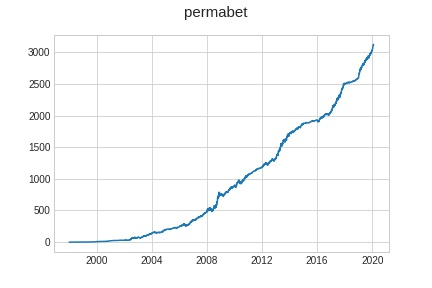

In [3]:
# Permabet computation
#####################################################################
%inline
@mx.memoize
def permabet_computation( response='logrtn_lead_30min_equalized', weight='one', verbose=True ):
    ''' 
    compute the returns of aa permabet strategy with lookhead that rebalances yearly
    '''
    logger = mx.Logger('permabet_computation', verbose=verbose)
    builder = FeatureBuilder()
    da = builder( data=None )    
    reg = mx.Regression( response=response, weight=weight, dk_lags=[10, 30], autocorr=[1, 13, 13*5] )
    with logger.timer( 'year on year permabet computation and regression'):
        permabet_regressions = []
        permabet_pnl = []
        ix = 0  
        # run a bunch of permabet regressions
        permabet_betas = []
        for split in mx.Freq.timesplits( da.time.to_series().min(), da.time.to_series().max(), mx.Freq.year ):
            sda = da.loc[split[0]:split[1]] 
            # compute the permabet with lookahead
            permabet_beta = (
                ( sda.loc[:,:,'one'] * sda.loc[:,:,response] ).mean(axis=0) 
                / ( sda.loc[:,:,'one'] * sda.loc[:,:,'one'].notnull() ).mean(axis=0)
            )
            sda = sda.assign_features( permabet=sda.loc[:,:,'one'] * permabet_beta )
            pr = reg.apply_series(
                sda.loc[:, :, 'permabet'].squeeze().to_series().fillna(0),
                sda.loc[:,:,response].squeeze().to_series().fillna(0)
            )
            permabet_betas.append( permabet_beta )
            permabet_pnl.append( pr.pop('pnl') )        
            pr.pop( 'hitRate' )
            pr['start'] = pd.to_datetime(sda.time.min().values)
            pr['end'] = pd.to_datetime(sda.time.max().values)
            pr['strategy'] = 'permabet'
            permabet_regressions.append( pr )             
        permabet_regressions = pd.DataFrame( permabet_regressions ).set_index( ['start', 'end'] )
        permabet_pnl = pd.concat( permabet_pnl )        
    return permabet_pnl, permabet_regressions, permabet_betas

permabet_pnl, permabet_regressions, permabet_betas = permabet_computation()
dh( 'Permabet ', h=2 )
dh( permabet_regressions )
fig = figure()
plot( permabet_pnl.cumsum() )
fig.suptitle( 'permabet', fontsize=15 )
disp( fig )
       

### Online learning model

,mean,std
features,,
cos_dayofmonth,-2.592226e-02,0.000955
cos_dayofweek,1.825136e-01,0.000894
cos_timeofday,7.130840e-02,0.007088
cos_weekofyear,-1.853680e-02,0.007110
logrtn_lag_1day,2.711025e-05,0.001116
logrtn_lag_1day_130.ew_mean,2.536962e-05,0.001101
logrtn_lag_1day_130.ew_sd,1.413549e-02,0.010483
logrtn_lag_1day_26.ew_mean,4.626549e-05,0.001117
logrtn_lag_1day_26.ew_sd,1.254195e-02,0.009228


,mean,std
features,,
cos_dayofmonth,0.699875,0.000356
cos_dayofweek,0.748315,0.000282
cos_timeofday,0.729424,0.000738
cos_weekofyear,0.699163,0.001482
logrtn_lag_1day,0.012612,0.009283
logrtn_lag_1day_130.ew_mean,0.002338,0.001705
logrtn_lag_1day_130.ew_sd,0.005903,0.003797
logrtn_lag_1day_26.ew_mean,0.005094,0.003692
logrtn_lag_1day_26.ew_sd,0.005976,0.003972


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.140307,0.497361,0.004299,0.000018,21.84203,8.319294,8.396001,0.970629,0.915622,0.86774,0.864989,883733400000000000,1580914800000000000


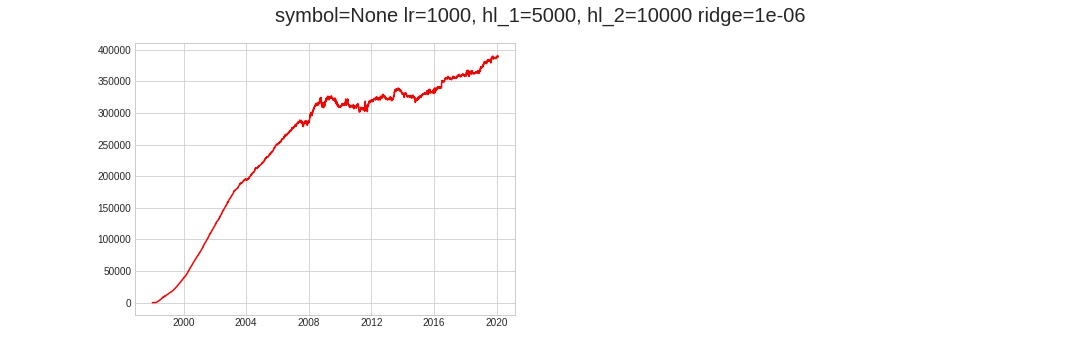

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.154651,0.453582,0.004753,0.000023,23.179184,7.579864,7.650453,0.962637,0.889998,0.824412,0.820724,883733400000000000,1580914800000000000


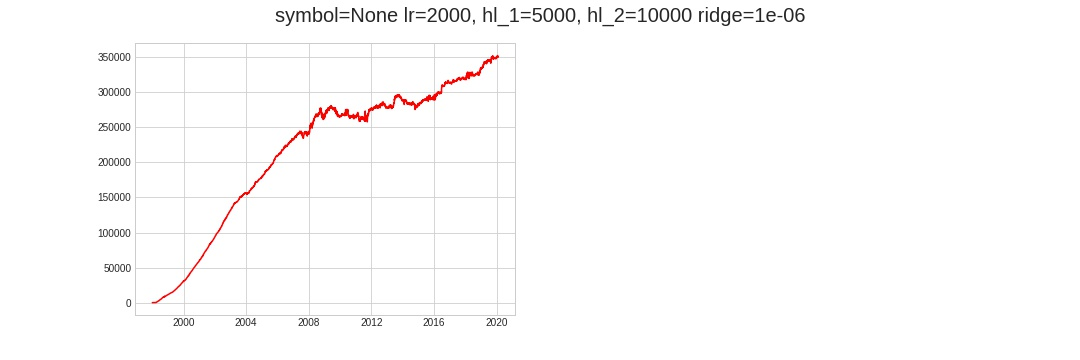

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.125748,0.542157,0.004019,0.000016,21.099665,9.095236,9.169578,0.976007,0.932161,0.894795,0.892675,883733400000000000,1580914800000000000


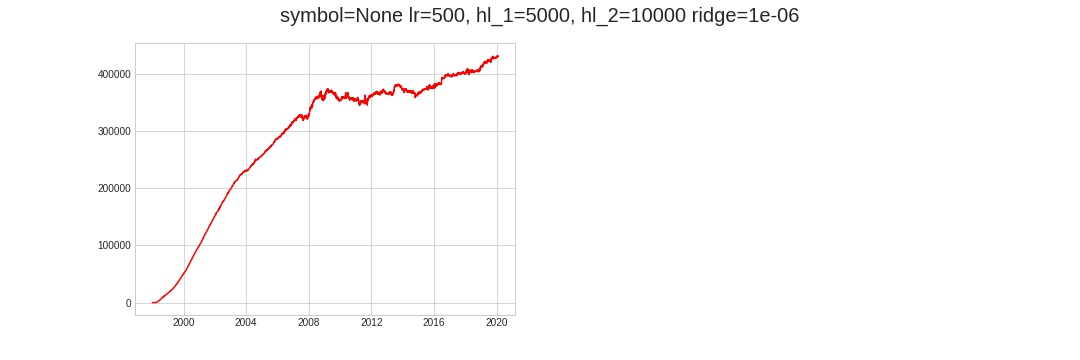

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.164291,0.287229,0.001619,0.000003,16.279852,4.739922,4.810483,0.955299,0.873975,0.802311,0.796703,883733400000000000,1580914800000000000


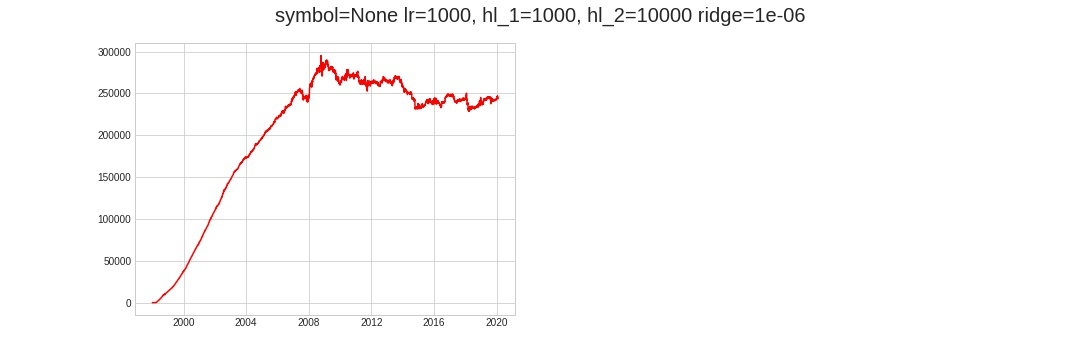

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.181661,0.261754,0.002224,0.000005,17.26869,4.332981,4.413126,0.940299,0.828866,0.735392,0.728813,883733400000000000,1580914800000000000


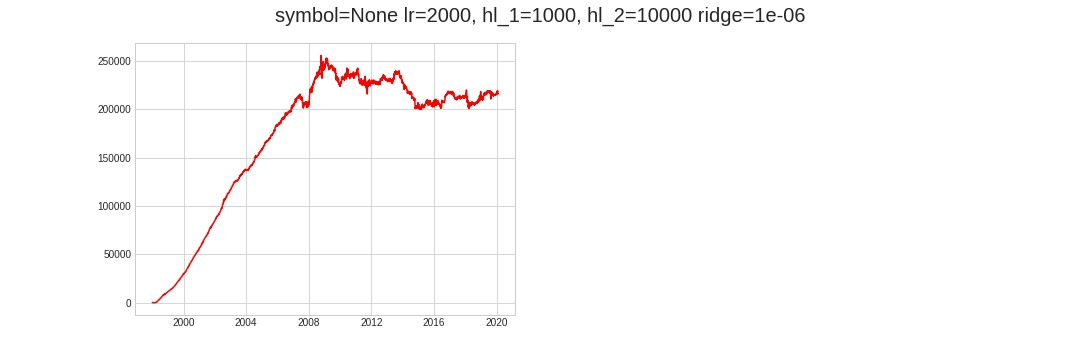

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997229,-0.141665,0.320813,0.001525,0.000002,15.82492,5.291089,5.377757,0.965926,0.905436,0.849753,0.844944,883733400000000000,1580914800000000000


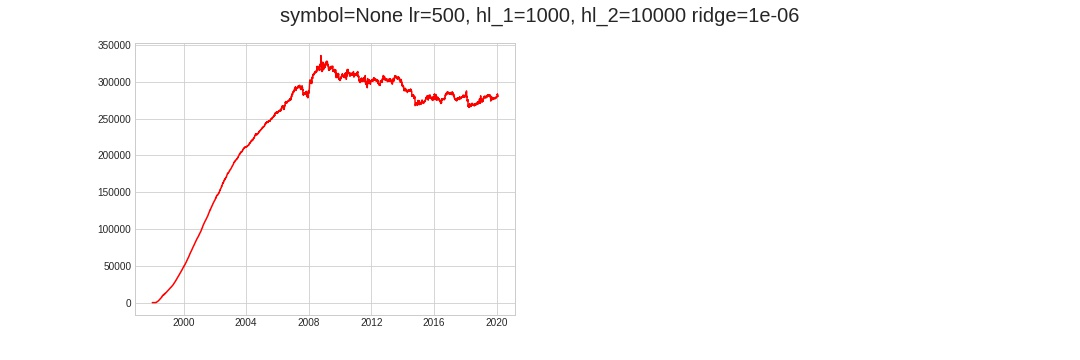

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997395,-0.136292,0.518734,0.004292,0.000018,21.717505,8.670817,8.744632,0.973894,0.925013,0.879527,0.877426,883733400000000000,1580914800000000000


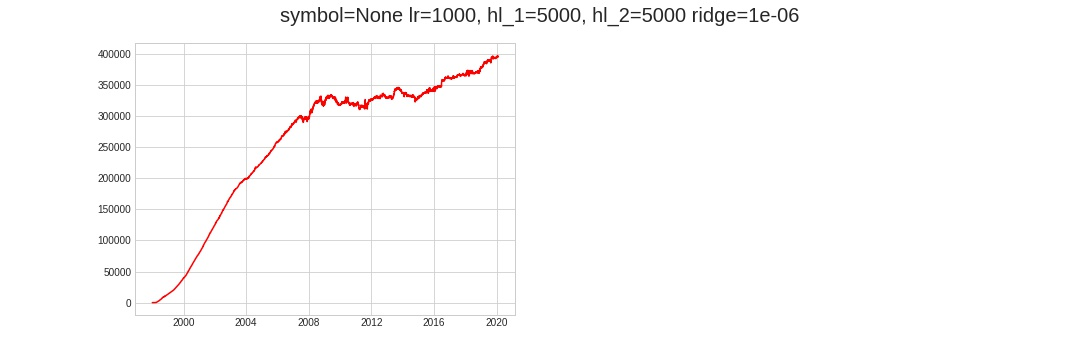

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997395,-0.150155,0.466924,0.004677,0.000022,22.702354,7.793825,7.853931,0.967105,0.903331,0.84245,0.839528,883733400000000000,1580914800000000000


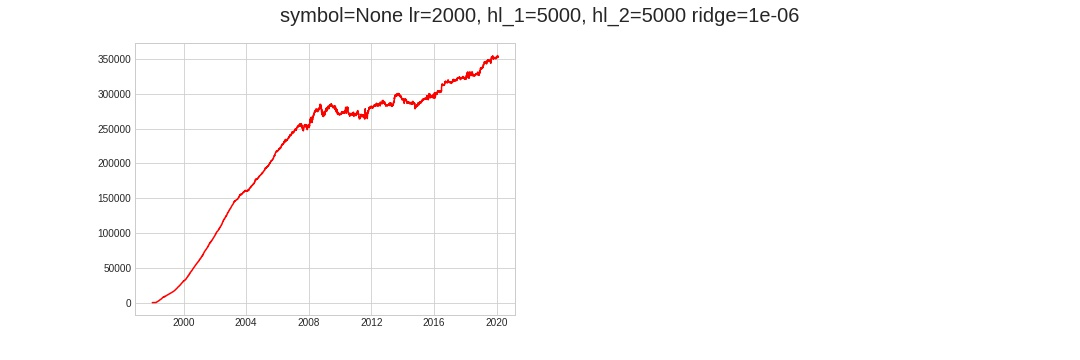

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_30,ac_1,ac_12,ac_72,ac_100,start,end
NaN,14218081,0.997395,-0.122506,0.572605,0.0041,0.000017,21.21204,9.601728,9.675125,0.978272,0.938725,0.90239,0.900692,883733400000000000,1580914800000000000


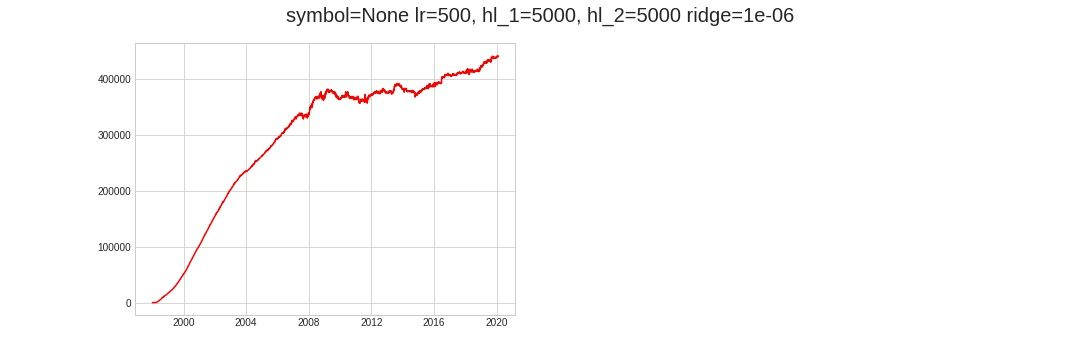

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


KeyboardInterrupt: 

In [4]:
# --- 30 min online model (INSAMPLE)----
#####################################################################
%inline
hps = mx.HPSet()    
hps.symbol = 'SPY'
hps.features = (
    [ 'logrtn_lag_overnight', 'logrtn_lag_weekend',
      'logrtn_lag_30min', 'logrtn_lag_1hr', 'logrtn_lag_1day',
      'logrtn_lag_30min_26.ew_sd',  'logrtn_lag_1day_26.ew_sd',
     'logrtn_lag_30min_130.ew_sd', 'logrtn_lag_1day_130.ew_sd',
     'logrtn_lag_30min_390.ew_sd', 'logrtn_lag_1day_390.ew_sd',
     'logrtn_lag_30min_26.ew_mean', 'logrtn_lag_1day_26.ew_mean',
     'logrtn_lag_30min_130.ew_mean', 'logrtn_lag_1day_130.ew_mean',
     'logrtn_lag_30min_390.ew_mean', 'logrtn_lag_1day_390.ew_mean',
     # 'logrtn_lag_intraday', 'logrtn_lag_intraweek',    'logrtn_lag_intramonth', 
     #'log_dollar_volume_30min', 'log_open_30min', 'log_dollar_volume_intraday', 'log_dollar_volume_intraweek',
#      'log_open_30min_26.ew_sd',  'log_dollar_volume_30min_26.ew_sd', 
#      'log_open_30min_130.ew_sd', 'log_dollar_volume_30min_130.ew_sd', 
#      'log_open_30min_390.ew_sd', 'log_dollar_volume_30min_390.ew_sd', 
#      'log_open_30min_26.ew_mean', 'log_dollar_volume_30min_26.ew_mean', 
#      'log_open_30min_130.ew_mean', 'log_dollar_volume_30min_130.ew_mean', 
#      'log_open_30min_390.ew_mean', 'log_dollar_volume_30min_390.ew_mean', 
    ]
    + ['cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek', 
       'cos_dayofmonth','sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear']
)
hps.response = 'logrtn_lead_30min_equalized'
hps.weight = 'one'
hps.lookhead = 12
hps.hl_1 = 100
hps.hl_2 = 10000      
hps.lr = 100
hps.algo = 'mbprox'
hps.loss = 'psr'
hps.ridge = 1e-3
hps.transformer = 'quadratic_transformer'


@mx.memoize
def compute_feature_sd_and_mean( features=hps.features ):
    builder = FeatureBuilder()
    da = builder( data=None )
    fsd = da.loc[:,:,features].std( dim='time' ).to_dataframe_mx()
    fmu = da.loc[:,:,features].mean( dim='time' ).to_dataframe_mx()
    return fsd, fmu

with mx.timer( 'compute_feature_sd_and_mean '):
    fsd, fmu = compute_feature_sd_and_mean()
disp( 'Feature batch means (mean and std across symbols)',  pd.concat( [fmu.mean(axis=0), fmu.std(axis=0)], axis=1  ).rename(columns={0:'mean', 1:'std'}), h=3 )
disp( 'Feature batch SD (mean and std across symbols)',  pd.concat( [fsd.mean(axis=0), fsd.std(axis=0)], axis=1  ).rename(columns={0:'mean', 1:'std'}), h=3 )

@mx.memoize
def run_one_configuration( hps, begin=0, end=-1, verbose=True ):
    ''' run one configuration end to end'''
    
    def quadratic_transformer( Xt ):
        '''    compute quadratic features transforms for online learning    '''
        Xo =  tr.einsum( 'tna,tnb->tnab', Xt, Xt )
        assert Xo.shape == (Xt.shape[0], Xt.shape[1], Xt.shape[2], Xt.shape[2] )
        Xo = Xo.reshape( Xt.shape[0], Xt.shape[1], -1 )
        return tr.cat( [Xt, Xo], dim=-1 )
    
    builder = FeatureBuilder()
    da = builder( data=None )    
    da_use = da.loc[:, :, list(hps.features) + [hps.response, hps.weight]].fillna( 0 )[begin:end]
    # make sure you don't squeeze out this dimension !
    if hps.symbol is not None:
        da_use = da_use.sel( symbol=[hps.symbol] )
    X = da_use.loc[:, :, list(hps.features)]
    Y = da_use.loc[:, :, [hps.response]]
    W = da_use.loc[:, :, [hps.weight]]    
    
    # normalize X and Y before fitting ... just for shits and giggles
    X = (X - X.mean( dim=['time','symbol']) )/ X.std( dim=['time','symbol'] )
    Y = (Y - Y.mean( dim=['time','symbol']) )/ Y.std( dim=['time','symbol'] )
    
    decay_1 = mx.Resolve.halflife( hps.hl_1 )['decay']
    hl_1 = mx.Resolve.halflife( hps.hl_1 )['halflife']
    decay_2 = mx.Resolve.halflife( hps.hl_2 )['decay']
    hl_2 = mx.Resolve.halflife( hps.hl_2 )['halflife']
    
    tr.cuda.empty_cache()    
    device = 'cuda'
    dtype = tr.float32

    # the linear rnn learner
    linear_rnn = mxtr.LinearRNN(
        lookahead=hps.lookhead, ridge=hps.ridge, loss=hps.loss, algo=hps.algo,
        decay_1=decay_1, decay_2=decay_2, lr=hps.lr,
        transformer=quadratic_transformer if hps.transformer == 'quadratic_transformer' else None, 
        verbose=verbose, 
    )        
    tr.cuda.empty_cache()
    Xt = tr.as_tensor( X.values, dtype=dtype, device=device )
    Yt = tr.as_tensor( Y.values, dtype=dtype, device=device )
    Wt = tr.as_tensor( W.values, dtype=dtype, device=device )
    Yht, meta, state = linear_rnn( Xt, Yt, Wt )
    Yh = Yht.to_dataarray( Y )
    wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
    #Yh = wins( Yh, features=Yh.features.values )
    
    reg = mx.Regression( dk_lags=[10, 30], autocorr=[1, 12, 72, 100],  )
    fig = figure( figsize=(15, 5 ) )            
    with timer( 'running regressions' ):
        rm = reg.regress( Yh, Y )
        ax = subplot( 121 )
        model_pnl = rm.pop( 'pnl' )
        rm['start'] = da_use.time.min().item()
        rm['end'] = da_use.time.max().item()
        rm.pop( 'hitRate' )
        ax.plot( model_pnl.cumsum(), '-r' )
        fig.suptitle( f'symbol={hps.symbol} lr={hps.lr}, hl_1={hps.hl_1}, hl_2={hps.hl_2} ridge={hps.ridge}', fontsize=20 )                    
    return Yh, Y, dict(hps=hps, fig=fig2format( fig ), rm=pd.DataFrame( rm, index=[hps.symbol]) )
 
for symbol in [None]: #+  ['SPY' , 'XLF', 'GDX', 'EEM', 'HYG', 'AGG', 'BND', 'VXX']:
    for hl_2 in [ 10000, 5000,]:
        for hl_1 in [5000, 1000 ]: 
            for lr in [1000, 2000, 500]:
                ridges = [1e-6] if symbol is None else [1e-6, 1e-10]
                for ridge in ridges:             #1e-1, 1e-3, , 1e-9
                    hpsc = hps.clone( symbol=symbol, ridge=ridge, lr=lr, hl_1=hl_1, hl_2=hl_2)
                    out = run_one_configuration( hpsc )   
                    disp( f'symbol={hpsc.symbol} lr={hpsc.lr}, hl_1={hpsc.hl_1}, hl_2={hpsc.hl_2} ridge={hpsc.ridge}', h=2 )
                    disp( hpsc, out[2]['rm'] )
                    display( out[2]['fig'] )


# fullsample results
* different HP grid (including `hl_2`
* float32 dtype